In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc("font", family='Microsoft YaHei')

# 设置不同扰动大小
epsilons = [0, .05, .1, .15, .2, .25, .3]
# 预训练模型
pretrained_model = "./data/lenet_mnist_model.pth"
#pretrained_model = "./data/mnist_cnn.pt"
# 是否使用cuda
use_cuda = True


def set_random_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

# 定义LeNet模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 设置种子，可复现
set_random_seed()

# 加载数据集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data_row', train=False, download=True, 
                   transform=transforms.Compose([transforms.ToTensor(),])),
    batch_size=1, shuffle=True)

# 定义设备
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 初始化网络
model = Net().to(device)

# 加载预训练模型
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 设置模型为评估模式
model.eval()


# FGSM算法
def fgsm_attack(image, epsilon, data_grad):
    # 收集数据梯度的元素符号
    sign_data_grad = data_grad.sign()
    # 通过调整输入图像的每个像素进行添加扰动
    perturbed_image = image + epsilon * sign_data_grad
    # 添加剪切以维持[0,1]范围
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回被扰动的图像
    return perturbed_image


def test(model, device, test_loader, epsilon):
    # 识别正确数
    correct = 0
    adv_examples = []
    
    # 遍历所有数据
    for data, target in test_loader:

        # 把数据和标签发送到设备
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        # 通过模型前向传递数据
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # 如果初始预测是错误的，不打断攻击，继续
        if init_pred.item() != target.item():
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 将梯度归零
        model.zero_grad()

        # 反向传播
        loss.backward()

        # 收集datagrad
        data_grad = data.grad.data

        # FGSM攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 重新分类受扰乱的图像
        output = model(perturbed_data)

        # 检查是否成功
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # 计算此epsilon的平均正确率
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 返回正确率和对抗示例
    return final_acc, adv_examples


accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

CUDA Available:  True
Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


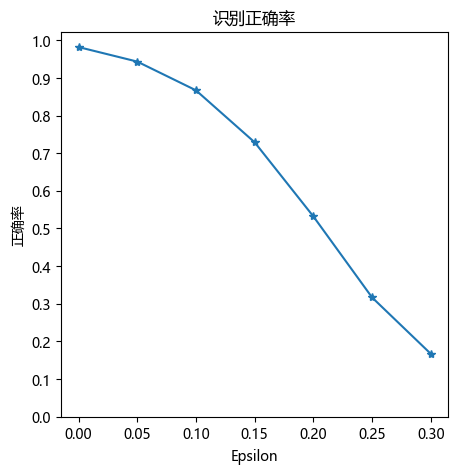

In [55]:
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("识别正确率")
plt.xlabel("Epsilon")
plt.ylabel("正确率")
plt.show()

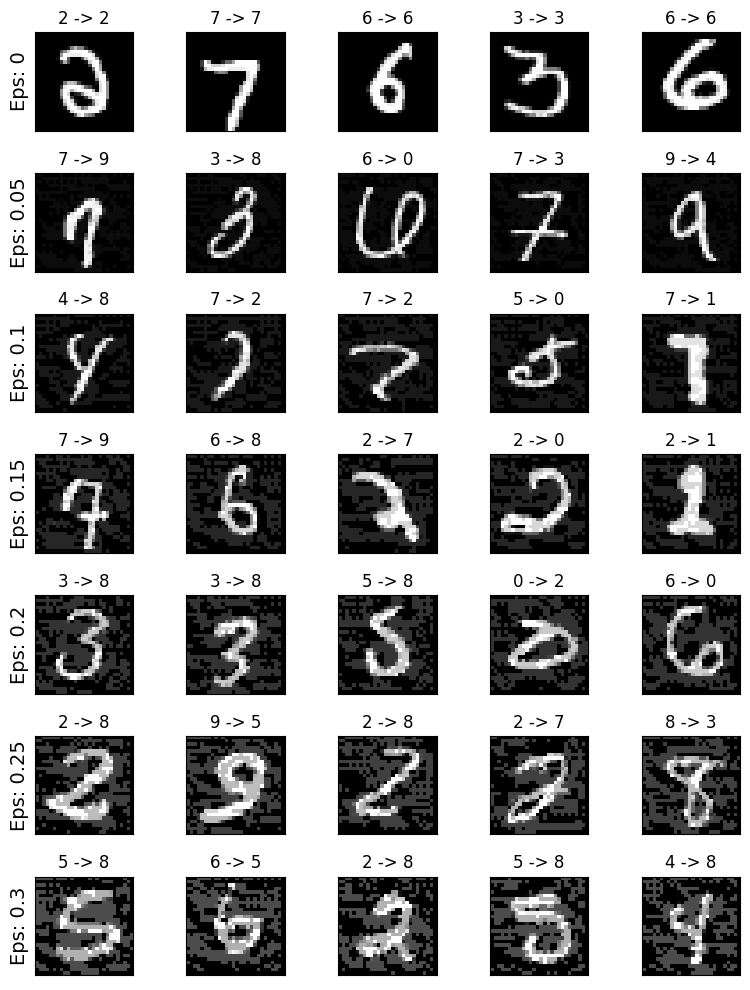

In [12]:
# 在每个epsilon上绘制几个对抗样本的例子
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, adv_ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(adv_ex, cmap="gray")
plt.tight_layout()
plt.show()

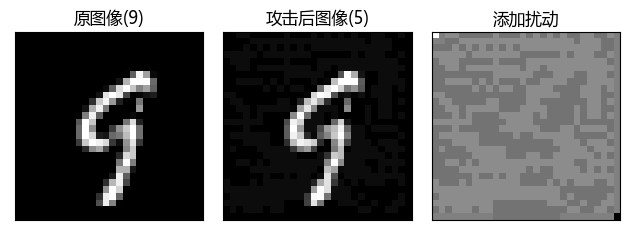

In [60]:
import matplotlib


# FGSM算法
def fgsm_attack(image, epsilon, data_grad):
    # 收集数据梯度的元素符号
    sign_data_grad = data_grad.sign()    
    noise = epsilon * sign_data_grad
    # 通过调整输入图像的每个像素进行添加扰动
    perturbed_image = image + noise
    # 添加剪切以维持[0,1]范围
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回被扰动的图像
    return perturbed_image, image, noise

for data, target in test_loader:
    # 把数据和标签发送到设备
    data, target = data.to(device), target.to(device)

    data.requires_grad = True

    # 通过模型前向传递数据
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]

    if init_pred.item() != target.item():
        continue

    # 计算损失
    loss = F.nll_loss(output, target)

    # 将所有现有的渐变归零
    model.zero_grad()

    # 计算后向传递模型的梯度
    loss.backward()

    # 收集datagrad
    data_grad = data.grad.data

    # FGSM攻击
    perturbed_data, init_data, noise_data = fgsm_attack(data, 0.05, data_grad)

    # 重新分类受扰乱的图像
    output = model(perturbed_data)

    # 检查是否成功
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        continue
    else:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        init_ex = init_data.squeeze().detach().cpu().numpy()
        noise_ex = noise_data.squeeze().detach().cpu().numpy()+0.5
        # adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        break

matplotlib.rc("font", family='Microsoft YaHei')
plt.subplot(1,3,1)
plt.imshow(init_ex, cmap="gray")
plt.title(f'原图像({init_pred.item()})')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1,3,2)
plt.imshow(adv_ex, cmap="gray")
plt.title(f'攻击后图像({final_pred.item()})')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1,3,3)
noise_ex[0][0]=1
noise_ex[27][27]=0
plt.imshow(noise_ex,cmap='gray')
plt.title('添加扰动')

plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.show()